## Install the required libararies

In [83]:
!pip install -q datasets ibm-watson pandas tqdm wordcloud

## Import the required libraries

In [88]:
import pandas as pd
from datasets import load_dataset
from datetime import datetime, timedelta
import random
import os

import requests
from ibm_watson import IAMTokenManager

from tqdm import tqdm

pd.set_option("display.max_rows", None)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns
pd.set_option("display.max_colwidth", None)  # Display full content of each cell
tqdm.pandas()

## Load the Ecommerce Datasets 
## Dataset Type - E-Commerce Customer Support Conversations

## Data Source - https://huggingface.co/datasets/NebulaByte/E-Commerce_Customer_Support_Conversations

In [89]:
dataset = load_dataset("NebulaByte/E-Commerce_Customer_Support_Conversations")
train_data = dataset["train"]
customer_conversation = train_data.to_pandas()[
    ["conversation"]
]  ### Consider the conversation column only

## Add Synthetic Data (Add call_recording_date and customer_location)

In [90]:
def random_date_generation(delta: int = 7):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=delta)
    random_timestamp = start_date + timedelta(
        days=random.randint(0, delta),
        hours=random.randint(0, 23),
        minutes=random.randint(0, 59),
        seconds=random.randint(0, 59),
    )
    return random_timestamp


customer_conversation["recording_date"] = [
    random_date_generation() for _ in range(len(customer_conversation))
]

locations = ["New York, NY",
            "Los Angeles, CA",
            "San Diego, CA",
            "San Francisco, CA",
            "Jacksonville, FL",
            "Seattle, WA",
            "Washington, D.C.",
            "Boston, MA"
            ]

customer_conversation["location"] = [
    random.choice(locations) for _ in range(len(customer_conversation))
]

## Preview the data

In [91]:
customer_conversation.head(2)

,conversation,recording_date,location
0,"Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you today?\n\nCustomer: Hi Tom, I'm trying to log in to my account to purchase an Oven Toaster Grill (OTG), but I'm unable to proceed as it's asking for mobile number or email verification. Can you help me with that?\n\nAgent: Sure, I can assist you with that. May I know your registered mobile number or email address, please?\n\nCustomer: My registered mobile number is +1 123-456-7890.\n\nAgent: Thank you. Let me check that for you. I'm sorry to inform you that we don't have this number on our records. Can you please confirm if this is the correct number?\n\nCustomer: Oh, I'm sorry. I might have registered with a different number. Can you please check with my email address instead? It's johndoe@email.com.\n\nAgent: Sure, let me check that for you. (After a few moments) I see that we have your email address on our records. We'll be sending you a verification code shortly. Please check your email and let me know once you receive it.\n\nCustomer: Okay, I received the code. What do I do with it?\n\nAgent: Please enter the verification code in the field provided and click on 'Verify'. Once your email address is verified, you'll be able to proceed with your purchase.\n\nCustomer: Okay, I entered the code, and it's verified now. Thank you for your help.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all. Thank you.\n\nAgent: You're welcome. Have a great day!",2024-09-15 21:22:04.825085,"Los Angeles, CA"
1,"Agent: Thank you for calling BrownBox customer support. My name is Alex. How may I assist you today?\n\nCustomer: Hi Alex. I recently received an email from BrownBox requesting me to ship back the computer monitor I purchased last week. Can you please tell me why I am being asked to ship it back?\n\nAgent: Sure, I'll be happy to help you with that. May I have your order number, please?\n\nCustomer: Yes, it's 789101.\n\nAgent: Thank you. Let me check the details of your order. (After a few seconds) I see that the monitor you purchased has been recalled by the manufacturer due to a technical issue. For safety reasons, we are requesting our customers to return the product, and we will be providing a full refund.\n\nCustomer: Oh, I see. That makes sense. Can you guide me through the process of returning the monitor?\n\nAgent: Of course. We will be sending you a prepaid shipping label via email within the next 24 hours. Please print the label, pack the monitor securely in its original packaging, and drop it off at any UPS store. Once we receive the product, we will initiate the refund process, and you will receive your money within 5-7 business days.\n\nCustomer: Okay, that sounds straightforward. Thank you for explaining the process to me.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all for now. Thank you for your help.\n\nAgent: You're welcome. If you have any other questions or concerns, please don't hesitate to reach out to us. Have a great day!\n\nCustomer: You too. Goodbye.\n\nAgent: Goodbye.",2024-09-14 17:07:55.825122,"New York, NY"


## Set the Variables

In [92]:
API_KEY = "##################################" ## Enter the API key genereted from IBM Watson platform
SERVICE_URL = (
    "https://us-south.ml.cloud.ibm.com/ml/v1/text/generation?version=2023-05-29"
)
INSTRUCT_MODEL_ID = "ibm/granite-13b-instruct-v2"
CHAT_MODEL_ID = "ibm/granite-13b-chat-v2"
PROJECT_ID = "d80ea387-8eaa-42db-8d24-43edef6c6f69"

## Function to generate bearer Token

In [93]:
def get_token(api_key: str) -> str:
    """Generates and returns the IAM token."""
    try:
        iam_token_manager = IAMTokenManager(apikey=api_key)
        return iam_token_manager.get_token()
    except Exception as e:
        raise Exception(f"Error obtaining IAM token: {str(e)}")

## Request body function

In [94]:
def create_request_body(model_id: str, input_text: str, max_tokens: int = 900) -> dict:
    """Creates the request body for the API call."""
    return {
        "input": input_text,
        "parameters": {
            "decoding_method": "greedy",
            "max_new_tokens": max_tokens,
            "repetition_penalty": 1.05,
        },
        "model_id": model_id,
        "project_id": PROJECT_ID,
        "moderations": {
            "hap": {
                "input": {
                    "enabled": True,
                    "threshold": 0.5,
                    "mask": {"remove_entity_value": True},
                },
                "output": {
                    "enabled": True,
                    "threshold": 0.5,
                    "mask": {"remove_entity_value": True},
                },
            }
        },
    }

## API request function

In [95]:
def make_api_request(body: dict, token: str, url: str) -> dict:
    """Makes the API request to the IBM Watson service."""
    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": f"Bearer {token}",
    }

    try:
        response = requests.post(url, headers=headers, json=body)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        raise Exception(f"API request failed: {str(e)}")

    return response.json()

## Chat message function wrapper

In [96]:
def get_chat_message(prompt, input, model_id):
    input_text = f"{prompt} \n {input}"

    # print(input_text)

    token = get_token(API_KEY)
    body = create_request_body(model_id, input_text)
    data = make_api_request(body, token, SERVICE_URL)

    # print(data)

    return data["results"][0]["generated_text"]

## Temporary -- Limit records (token control)

In [97]:
customer_conversation = customer_conversation.loc[:249]

## Sentiment Analysis

In [98]:
sentiment_analysis_prompt = """Analyze the sentiment of the following text and only return one word: 'positive', 'negative', or 'neutral' without any explanation or 
                               additional information. Text: """

customer_conversation["customer_sentiment"] = customer_conversation.progress_apply(
    lambda row: get_chat_message(
        sentiment_analysis_prompt, row["conversation"], INSTRUCT_MODEL_ID
    ),
    axis=1,
)

100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


In [99]:
customer_conversation.head(2)

,conversation,recording_date,location,customer_sentiment
0,"Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you today?\n\nCustomer: Hi Tom, I'm trying to log in to my account to purchase an Oven Toaster Grill (OTG), but I'm unable to proceed as it's asking for mobile number or email verification. Can you help me with that?\n\nAgent: Sure, I can assist you with that. May I know your registered mobile number or email address, please?\n\nCustomer: My registered mobile number is +1 123-456-7890.\n\nAgent: Thank you. Let me check that for you. I'm sorry to inform you that we don't have this number on our records. Can you please confirm if this is the correct number?\n\nCustomer: Oh, I'm sorry. I might have registered with a different number. Can you please check with my email address instead? It's johndoe@email.com.\n\nAgent: Sure, let me check that for you. (After a few moments) I see that we have your email address on our records. We'll be sending you a verification code shortly. Please check your email and let me know once you receive it.\n\nCustomer: Okay, I received the code. What do I do with it?\n\nAgent: Please enter the verification code in the field provided and click on 'Verify'. Once your email address is verified, you'll be able to proceed with your purchase.\n\nCustomer: Okay, I entered the code, and it's verified now. Thank you for your help.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all. Thank you.\n\nAgent: You're welcome. Have a great day!",2024-09-15 21:22:04.825085,"Los Angeles, CA",positive
1,"Agent: Thank you for calling BrownBox customer support. My name is Alex. How may I assist you today?\n\nCustomer: Hi Alex. I recently received an email from BrownBox requesting me to ship back the computer monitor I purchased last week. Can you please tell me why I am being asked to ship it back?\n\nAgent: Sure, I'll be happy to help you with that. May I have your order number, please?\n\nCustomer: Yes, it's 789101.\n\nAgent: Thank you. Let me check the details of your order. (After a few seconds) I see that the monitor you purchased has been recalled by the manufacturer due to a technical issue. For safety reasons, we are requesting our customers to return the product, and we will be providing a full refund.\n\nCustomer: Oh, I see. That makes sense. Can you guide me through the process of returning the monitor?\n\nAgent: Of course. We will be sending you a prepaid shipping label via email within the next 24 hours. Please print the label, pack the monitor securely in its original packaging, and drop it off at any UPS store. Once we receive the product, we will initiate the refund process, and you will receive your money within 5-7 business days.\n\nCustomer: Okay, that sounds straightforward. Thank you for explaining the process to me.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all for now. Thank you for your help.\n\nAgent: You're welcome. If you have any other questions or concerns, please don't hesitate to reach out to us. Have a great day!\n\nCustomer: You too. Goodbye.\n\nAgent: Goodbye.",2024-09-14 17:07:55.825122,"New York, NY",negative


## Text Summarization

In [100]:
call_summary_prompt = (
    "Summarize the below call recording. Maxumum 100 Words. Recording: "
)


customer_conversation["call_summary"] = customer_conversation.progress_apply(
    lambda row: get_chat_message(
        call_summary_prompt, row["conversation"], CHAT_MODEL_ID
    ),
    axis=1,
)

100%|██████████| 250/250 [05:39<00:00,  1.36s/it]


In [101]:
customer_conversation.head(2)

,conversation,recording_date,location,customer_sentiment,call_summary
0,"Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you today?\n\nCustomer: Hi Tom, I'm trying to log in to my account to purchase an Oven Toaster Grill (OTG), but I'm unable to proceed as it's asking for mobile number or email verification. Can you help me with that?\n\nAgent: Sure, I can assist you with that. May I know your registered mobile number or email address, please?\n\nCustomer: My registered mobile number is +1 123-456-7890.\n\nAgent: Thank you. Let me check that for you. I'm sorry to inform you that we don't have this number on our records. Can you please confirm if this is the correct number?\n\nCustomer: Oh, I'm sorry. I might have registered with a different number. Can you please check with my email address instead? It's johndoe@email.com.\n\nAgent: Sure, let me check that for you. (After a few moments) I see that we have your email address on our records. We'll be sending you a verification code shortly. Please check your email and let me know once you receive it.\n\nCustomer: Okay, I received the code. What do I do with it?\n\nAgent: Please enter the verification code in the field provided and click on 'Verify'. Once your email address is verified, you'll be able to proceed with your purchase.\n\nCustomer: Okay, I entered the code, and it's verified now. Thank you for your help.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all. Thank you.\n\nAgent: You're welcome. Have a great day!",2024-09-15 21:22:04.825085,"Los Angeles, CA",positive,"\n\nThe customer was able to successfully verify their email address and complete the purchase process. The agent was patient and helpful throughout the interaction, ensuring that the customer's issue was resolved.\n"
1,"Agent: Thank you for calling BrownBox customer support. My name is Alex. How may I assist you today?\n\nCustomer: Hi Alex. I recently received an email from BrownBox requesting me to ship back the computer monitor I purchased last week. Can you please tell me why I am being asked to ship it back?\n\nAgent: Sure, I'll be happy to help you with that. May I have your order number, please?\n\nCustomer: Yes, it's 789101.\n\nAgent: Thank you. Let me check the details of your order. (After a few seconds) I see that the monitor you purchased has been recalled by the manufacturer due to a technical issue. For safety reasons, we are requesting our customers to return the product, and we will be providing a full refund.\n\nCustomer: Oh, I see. That makes sense. Can you guide me through the process of returning the monitor?\n\nAgent: Of course. We will be sending you a prepaid shipping label via email within the next 24 hours. Please print the label, pack the monitor securely in its original packaging, and drop it off at any UPS store. Once we receive the product, we will initiate the refund process, and you will receive your money within 5-7 business days.\n\nCustomer: Okay, that sounds straightforward. Thank you for explaining the process to me.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all for now. Thank you for your help.\n\nAgent: You're welcome. If you have any other questions or concerns, please don't hesitate to reach out to us. Have a great day!\n\nCustomer: You too. Goodbye.\n\nAgent: Goodbye.",2024-09-14 17:07:55.825122,"New York, NY",negative,"\n\nIn this call recording, the customer expresses concern about a recall notice for a computer monitor they recently purchased from BrownBox. The agent provides clear instructions on how to return the product and ensures the customer that a full refund will be issued. The interaction demonstrates effective customer service and transparency in addressing the customer's issue."


## Feature Extraction

In [102]:
feature_extraction_prompt = """
For the below conversation i want to do feature extraction.The output should be in json format. 
The output must contains following details issue, action_taken, product_interest, customer_details, resolution,additional_support_needed. 
No explanation needed. Just the json output. 
In case if customer_details are not present populate it as NULL. 
In case any other details are not present populate as NA. But tags must be present. 
Do not make up information if it is not available in the below conversation. Conversation - 
"""
customer_conversation["feature_extraction"] = customer_conversation.progress_apply(
    lambda row: get_chat_message(
        feature_extraction_prompt, row["conversation"], CHAT_MODEL_ID
    ),
    axis=1,
)

100%|██████████| 250/250 [18:29<00:00,  4.44s/it]


In [103]:
customer_conversation.head(2)

,conversation,recording_date,location,customer_sentiment,call_summary,feature_extraction
0,"Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you today?\n\nCustomer: Hi Tom, I'm trying to log in to my account to purchase an Oven Toaster Grill (OTG), but I'm unable to proceed as it's asking for mobile number or email verification. Can you help me with that?\n\nAgent: Sure, I can assist you with that. May I know your registered mobile number or email address, please?\n\nCustomer: My registered mobile number is +1 123-456-7890.\n\nAgent: Thank you. Let me check that for you. I'm sorry to inform you that we don't have this number on our records. Can you please confirm if this is the correct number?\n\nCustomer: Oh, I'm sorry. I might have registered with a different number. Can you please check with my email address instead? It's johndoe@email.com.\n\nAgent: Sure, let me check that for you. (After a few moments) I see that we have your email address on our records. We'll be sending you a verification code shortly. Please check your email and let me know once you receive it.\n\nCustomer: Okay, I received the code. What do I do with it?\n\nAgent: Please enter the verification code in the field provided and click on 'Verify'. Once your email address is verified, you'll be able to proceed with your purchase.\n\nCustomer: Okay, I entered the code, and it's verified now. Thank you for your help.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all. Thank you.\n\nAgent: You're welcome. Have a great day!",2024-09-15 21:22:04.825085,"Los Angeles, CA",positive,"\n\nThe customer was able to successfully verify their email address and complete the purchase process. The agent was patient and helpful throughout the interaction, ensuring that the customer's issue was resolved.\n","\n\nOutput in JSON format:\n{\n ""issue"": ""customer is unable to proceed with purchasing an OTG due to mobile number or email verification issue"",\n ""action_taken"": ""provided assistance in verifying the email address"",\n ""product_interest"": ""OTG"",\n ""customer_details"": {\n ""name"": ""John Doe"",\n ""email"": ""johndoe@email.com""\n },\n ""resolution"": ""email address verified and issue resolved"",\n ""additional_support_needed"": ""NA""\n}\n\nNote: In case if the customer_details are not present, populate it as NULL. In case any other details are not present, populate as NA. But tags must be present."
1,"Agent: Thank you for calling BrownBox customer support. My name is Alex. How may I assist you today?\n\nCustomer: Hi Alex. I recently received an email from BrownBox requesting me to ship back the computer monitor I purchased last week. Can you please tell me why I am being asked to ship it back?\n\nAgent: Sure, I'll be happy to help you with that. May I have your order number, please?\n\nCustomer: Yes, it's 789101.\n\nAgent: Thank you. Let me check the details of your order. (After a few seconds) I see that the monitor you purchased has been recalled by the manufacturer due to a technical issue. For safety reasons, we are requesting our customers to return the product, and we will be providing a full refund.\n\nCustomer: Oh, I see. That makes sense. Can you guide me through the process of returning the monitor?\n\nAgent: Of course. We will be sending you a prepaid shipping label via email within the next 24 hours. Please print the label, pack the monitor securely in its original packaging, and drop it off at any UPS store. Once we receive the product, we will initiate the refund process, and you will receive your money within 5-7 business days.\n\nCustomer: Okay, that sounds straightforward. Thank you for explaining the process to me.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all for now. Thank you for your help.\n\nAgent: You're welcome. If you have any other questions or concerns, please don't hesitate to reach ou

## As the feature extraction data contains json data along with text values, we have to do further data manipulation to extract the json data.

In [104]:
import json
import re

# Function to extract JSON from the text
def extract_json_from_text(text):
    try:
        # Use regular expressions to extract the JSON part
        json_match = re.search(r"\{.*\}", text, re.DOTALL)
        if json_match:
            json_str = json_match.group(0)
            json_data = json.loads(json_str)  # Parse the JSON string into a dictionary

            # Ensure all required tags are present
            json_data["issue"] = json_data.get("issue", "NA")
            json_data["action_taken"] = json_data.get("action_taken", "NA")
            json_data["product_interest"] = json_data.get("product_interest", "NA")
            json_data["customer_details"] = json_data.get(
                "customer_details", None
            )  # Set as NULL if absent
            json_data["resolution"] = json_data.get("resolution", "NA")
            json_data["additional_support_needed"] = json_data.get(
                "additional_support_needed", "NA"
            )

            return json.dumps(json_data)
        else:
            return None
    except (json.JSONDecodeError, TypeError):
        return None  # Return None if it's not a valid JSON


# Apply the function to the column
customer_conversation["feature_extraction"] = customer_conversation[
    "feature_extraction"
].progress_apply(extract_json_from_text)

100%|██████████| 250/250 [00:00<00:00, 39015.33it/s]


In [105]:
customer_conversation.head(2)

,conversation,recording_date,location,customer_sentiment,call_summary,feature_extraction
0,"Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you today?\n\nCustomer: Hi Tom, I'm trying to log in to my account to purchase an Oven Toaster Grill (OTG), but I'm unable to proceed as it's asking for mobile number or email verification. Can you help me with that?\n\nAgent: Sure, I can assist you with that. May I know your registered mobile number or email address, please?\n\nCustomer: My registered mobile number is +1 123-456-7890.\n\nAgent: Thank you. Let me check that for you. I'm sorry to inform you that we don't have this number on our records. Can you please confirm if this is the correct number?\n\nCustomer: Oh, I'm sorry. I might have registered with a different number. Can you please check with my email address instead? It's johndoe@email.com.\n\nAgent: Sure, let me check that for you. (After a few moments) I see that we have your email address on our records. We'll be sending you a verification code shortly. Please check your email and let me know once you receive it.\n\nCustomer: Okay, I received the code. What do I do with it?\n\nAgent: Please enter the verification code in the field provided and click on 'Verify'. Once your email address is verified, you'll be able to proceed with your purchase.\n\nCustomer: Okay, I entered the code, and it's verified now. Thank you for your help.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all. Thank you.\n\nAgent: You're welcome. Have a great day!",2024-09-15 21:22:04.825085,"Los Angeles, CA",positive,"\n\nThe customer was able to successfully verify their email address and complete the purchase process. The agent was patient and helpful throughout the interaction, ensuring that the customer's issue was resolved.\n","{""issue"": ""customer is unable to proceed with purchasing an OTG due to mobile number or email verification issue"", ""action_taken"": ""provided assistance in verifying the email address"", ""product_interest"": ""OTG"", ""customer_details"": {""name"": ""John Doe"", ""email"": ""johndoe@email.com""}, ""resolution"": ""email address verified and issue resolved"", ""additional_support_needed"": ""NA""}"
1,"Agent: Thank you for calling BrownBox customer support. My name is Alex. How may I assist you today?\n\nCustomer: Hi Alex. I recently received an email from BrownBox requesting me to ship back the computer monitor I purchased last week. Can you please tell me why I am being asked to ship it back?\n\nAgent: Sure, I'll be happy to help you with that. May I have your order number, please?\n\nCustomer: Yes, it's 789101.\n\nAgent: Thank you. Let me check the details of your order. (After a few seconds) I see that the monitor you purchased has been recalled by the manufacturer due to a technical issue. For safety reasons, we are requesting our customers to return the product, and we will be providing a full refund.\n\nCustomer: Oh, I see. That makes sense. Can you guide me through the process of returning the monitor?\n\nAgent: Of course. We will be sending you a prepaid shipping label via email within the next 24 hours. Please print the label, pack the monitor securely in its original packaging, and drop it off at any UPS store. Once we receive the product, we will initiate the refund process, and you will receive your money within 5-7 business days.\n\nCustomer: Okay, that sounds straightforward. Thank you for explaining the process to me.\n\nAgent: You're welcome. Is there anything else I can assist you with?\n\nCustomer: No, that's all for now. Thank you for your help.\n\nAgent: You're welcome. If you have any other questions or concerns, please don't hesitate to reach out to us. Have a great day!\n\nCustomer: You too. Goodbye.\n\nAgent: Goodbye.",2024-09-14 17:07:55.825122,"New York, NY",negative,"\n\nIn this call recording, the customer expresses concern about a recall notice for 

In [106]:
customer_conversation.replace('', 'unknown', inplace=True)

## Save the data as json file

In [107]:
# Assuming customer_conversation is your DataFrame
#df = customer_conversation.applymap(
   # lambda x: x.replace('"', "") if isinstance(x, str) else x
#)
#df = df.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)
#df = df.applymap(lambda x: x.replace("\n", "") if isinstance(x, str) else x)

customer_conversation.to_json(
    os.path.join(os.getcwd(), "result.json"),
    orient="records",
    indent=4,
    date_format="iso"
)


## Create Metrice

In [108]:
import plotly.express as px
import pandas as pd
import os
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import warnings
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from io import BytesIO
import base64

warnings.filterwarnings("ignore")

## Customer Sentiment by Day

In [109]:
df = pd.read_json(os.path.join(os.getcwd(), "result.json"))
df["recording_date"] = pd.to_datetime(df["recording_date"]).dt.date

df_grouped = (
    df.groupby(["recording_date", "customer_sentiment"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
df_grouped["total_calls"] = df_grouped[
    ["positive", "neutral", "negative", "unknown"]
].sum(axis=1)

df_melted = df_grouped.melt(
    id_vars=["recording_date", "total_calls"],
    value_vars=["positive", "neutral", "negative", "unknown"],
    var_name="Sentiment",
    value_name="Count",
)

fig = px.bar(
    df_melted,
    x="recording_date",
    y="Count",
    color="Sentiment",
    barmode="group",
    title="Customer Sentiment Analysis by Day",
    labels={
        "recording_date": "Date",
    },
    text="Count",
    range_color={"black", "blue", "yellow"},
)

for date, total in zip(df_grouped["recording_date"], df_grouped["total_calls"]):
    fig.add_annotation(
        x=date,
        y=max(df_melted["Count"]),
        text=f"Total:{total}",
        showarrow=False,
        yshift=10,
        font=dict(size=10, color="Black"),
    )

fig.show()

## Top 10 User Interest (Categories)

In [110]:
df = pd.read_json(os.path.join(os.getcwd(), "result.json"))

def extract_categories(json_str):
    try:
        # Attempt to parse the JSON and return the 'categories' key
        parsed_json = json.loads(json_str)
        return str(parsed_json.get("product_interest", None))
    except (TypeError, json.JSONDecodeError):
        # Handle missing or invalid JSON
        return "Nothing"


df["categories"] = df["feature_extraction"].apply(extract_categories)

In [111]:
df = df.loc[(df["categories"] != "Nothing")]
category_counts = df["categories"].value_counts()

top_categories = category_counts.head(10)

# Create a bar chart
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=top_categories.index,
        y=top_categories.values,
        # marker_color='blue'
    )
)

# Customize layout
fig.update_layout(
    title="Total Calls Based on Top 10 Categories",
    xaxis_title="Categories",
    yaxis_title="Number of Calls",
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()

## Word Cloud Dashboard

In [112]:
df = pd.read_json(os.path.join(os.getcwd(), "result.json"))

df["categories"] = df["feature_extraction"].apply(extract_categories)


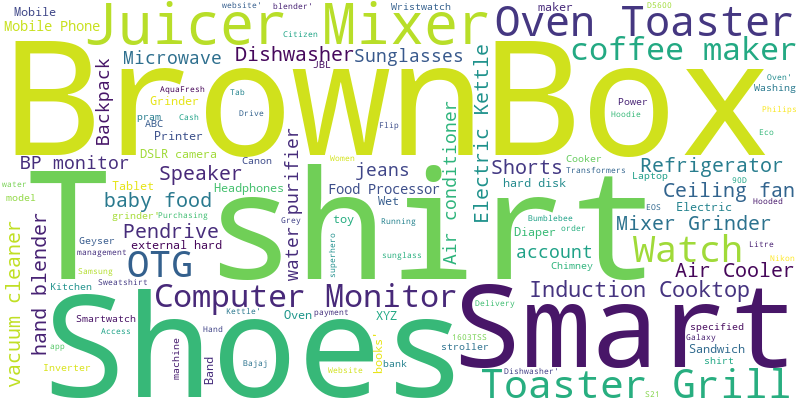

In [113]:
words = df["categories"].to_list()
words = " ".join(words)
words = words.replace("/", " ").replace("Nothing", "")

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words)

# Save the word cloud to a bytes object
img_buffer = BytesIO()
wordcloud.to_image().save(img_buffer, format="PNG")
img_buffer.seek(0)

# Encode the image in base64 to embed in Plotly
img_base64 = base64.b64encode(img_buffer.read()).decode("utf-8")

# Create a Plotly figure to display the image
fig = go.Figure()

# Add the image to the figure
fig.add_layout_image(
    dict(
        source=f"data:image/png;base64,{img_base64}",
        xref="paper",
        yref="paper",
        x=0.5,
        y=0.5,  # Position at the center
        sizex=1,
        sizey=1,  # Scale to fit
        xanchor="center",
        yanchor="middle",
    )
)

# Update the layout to remove axes and padding
fig.update_layout(
    width=800,
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
)

# Show the figure
fig.show()

## Location Wise call records

In [114]:
df = pd.read_json(os.path.join(os.getcwd(), "result.json"))
calls_per_location = df.groupby("location").size().reset_index(name="total_calls")

calls_per_location

,location,total_calls
0,"Boston, MA",28
1,"Jacksonville, FL",22
2,"Los Angeles, CA",38
3,"New York, NY",32
4,"San Diego, CA",34
5,"San Francisco, CA",37
6,"Seattle, WA",27
7,"Washington, D.C.",32


In [115]:
# Geographical coordinates for the specified locations
location_coords = {
    "New York, NY": (40.7128, -74.0060),
    "Los Angeles, CA": (34.0522, -118.2437),
    "San Diego, CA": (32.7157, -117.1611),
    "San Francisco, CA": (37.7749, -122.4194),
    "Jacksonville, FL": (30.3322, -81.6557),
    "Seattle, WA": (47.6062, -122.3321),
    "Washington, D.C.": (38.9072, -77.0369),
    "Boston, MA": (42.3601, -71.0589)
}

# Add latitude and longitude to the DataFrame
calls_per_location["latitude"] = calls_per_location["location"].map(
    lambda loc: location_coords[loc][0]
)
calls_per_location["longitude"] = calls_per_location["location"].map(
    lambda loc: location_coords[loc][1]
)
calls_per_location.head()

,location,total_calls,latitude,longitude
0,"Boston, MA",28,42.3601,-71.0589
1,"Jacksonville, FL",22,30.3322,-81.6557
2,"Los Angeles, CA",38,34.0522,-118.2437
3,"New York, NY",32,40.7128,-74.0060
4,"San Diego, CA",34,32.7157,-117.1611


In [127]:
# Create a heatmap using Plotly
fig = go.Figure(
    data=go.Scattergeo(
        lat=calls_per_location["latitude"],
        lon=calls_per_location["longitude"],
        mode="markers",
        marker=dict(
            size=calls_per_location[
                "total_calls"
            ],  
            color=calls_per_location["total_calls"],
            colorscale="Viridis",
            colorbar=dict(title="Number of Calls"),
        ),
        text=calls_per_location["location"],  
    )
)

# Update layout for better presentation
fig.update_layout(
    title="Heatmap of Calls by Location",
    geo=dict(
        scope="usa",
        projection=dict(type="albers usa"),
        showland=True,
        landcolor="rgb(240, 240, 240)",
        countrycolor="rgb(255, 255, 255)",
        showocean=True,
        oceancolor="rgb(0, 204, 255)",
        showcoastlines=True,
        coastlinecolor="rgb(0, 0, 0)",
    ),
)

# Show the figure
fig.show()